In [1]:
import sys
import random
from pathlib import Path

import torch
import torchaudio
import torchvision.transforms as T

import matplotlib.pyplot as plt

sys.path.append('..')
from ar.utils.nn import image_feature_extractor
from ar.metrics import accuracy, top_5_accuracy
from ar.utils.engine import train_one_epoch, evaluate


In [2]:
!mkdir -p ../data/speech_command

In [3]:
ds = torchaudio.datasets.SPEECHCOMMANDS('../data/speech_command', download=True)

In [4]:
classes = Path('../data/speech_command/SpeechCommands/speech_commands_v0.02')
classes = [p.stem for p in classes.iterdir()]
class2idx = {c: i for i, c in enumerate(classes)}

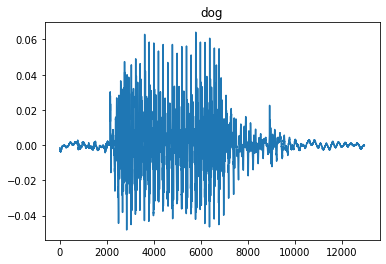

In [5]:
waveform, sample_rate, label, *_ = ds[random.randint(0, len(ds))]
plt.title(label)
plt.plot(waveform[0].numpy());

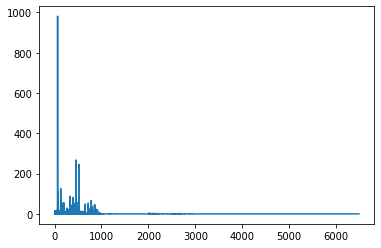

In [6]:
fft = torch.rfft(waveform, signal_ndim=1)
fft = fft[..., 0].pow(2) + fft[..., 0].pow(2)
plt.plot(fft[0]);

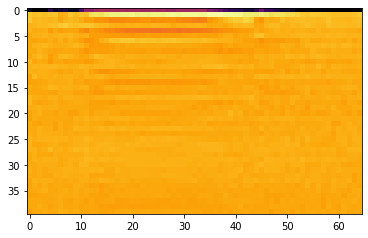

In [7]:
tfm = torchaudio.transforms.MFCC(sample_rate)
mcc = tfm(waveform)
mcc.size()

plt.imshow(mcc.squeeze().numpy(), cmap='inferno')

In [8]:
class TransformableDataset(object):

    def __init__(self, ds, transforms=None, target_transforms=None):
        self.ds = ds
        self.transforms = transforms
        self.target_transforms = target_transforms
    
    def __len__(self): return len(self.ds)

    def __getitem__(self, idx):
        wf, sr, label, *remaining = self.ds[idx]
        if self.transforms is not None:
            wf = self.transforms(wf)
        
        if self.target_transforms is not None:
            label = self.target_transforms(label)
        
        return tuple([wf, sr, label, *remaining])


In [9]:
train_ds = torchaudio.datasets.SPEECHCOMMANDS(
    '../data/speech_command')
    
valid_ds = torchaudio.datasets.SPEECHCOMMANDS(
    '../data/speech_command')

In [10]:
train_len = int(len(train_ds) * .9)
rand_idx = torch.randperm(len(train_ds))

train_ds = torch.utils.data.Subset(train_ds, rand_idx[:train_len])
valid_ds = torch.utils.data.Subset(valid_ds, rand_idx[train_len:])


In [11]:
def collate_fn(batch):
    wf, sr, labels, *_ = zip(*batch)

    for w in wf: w.squeeze_()
    wf = torch.nn.utils.rnn.pad_sequence(
        wf, batch_first=True, padding_value=0.)
    wf = wf.unsqueeze(1)
    wf = tfm(wf)
    wf = wf.repeat(1, 3, 1, 1)
    return wf, torch.as_tensor([class2idx[o] for o in labels])

train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=64, collate_fn=collate_fn, pin_memory=True)

valid_dl = torch.utils.data.DataLoader(
    valid_ds, batch_size=64, collate_fn=collate_fn, pin_memory=True)

In [16]:
x, y = next(iter(train_dl))
x.size(), y.size()

(torch.Size([64, 3, 40, 81]), torch.Size([64]))

In [13]:
import sys
sys.path.append('..')

In [14]:

resnet, feat = image_feature_extractor('resnet18')

device = torch.device('cuda')

model = torch.nn.Sequential(
    resnet,
    torch.nn.Flatten(1),
    torch.nn.Linear(feat, 512),
    torch.nn.Dropout(.5),
    torch.nn.Linear(512, len(classes)),
    torch.nn.LogSoftmax(-1))

model.to(device)
optimzer = torch.optim.Adam(model.parameters(), lr=3e-5)
loss_fn = torch.nn.NLLLoss()

In [15]:
for epoch in range(5):
    train_one_epoch(train_dl, model, optimzer, loss_fn, epoch, device=device, print_freq=100)
    evaluate(valid_dl, model, loss_fn, metrics=[accuracy, top_5_accuracy], device=device)


Epoch[0] [100/1489] loss: 3.672948 lr: 0.000030 time_per_step: 0.258760
Epoch[0] [200/1489] loss: 3.459269 lr: 0.000030 time_per_step: 0.238041
Epoch[0] [300/1489] loss: 3.255252 lr: 0.000030 time_per_step: 0.239365
Epoch[0] [400/1489] loss: 3.031168 lr: 0.000030 time_per_step: 0.380274
Epoch[0] [500/1489] loss: 2.807864 lr: 0.000030 time_per_step: 0.243484
Epoch[0] [600/1489] loss: 2.607576 lr: 0.000030 time_per_step: 0.315961
Epoch[0] [700/1489] loss: 2.425514 lr: 0.000030 time_per_step: 0.267639
Epoch[0] [800/1489] loss: 2.267526 lr: 0.000030 time_per_step: 0.296519
Epoch[0] [900/1489] loss: 2.134863 lr: 0.000030 time_per_step: 0.243659
Epoch[0] [1000/1489] loss: 2.015997 lr: 0.000030 time_per_step: 0.245242
Epoch[0] [1100/1489] loss: 1.911696 lr: 0.000030 time_per_step: 0.316703
Epoch[0] [1200/1489] loss: 1.823388 lr: 0.000030 time_per_step: 0.242039
Epoch[0] [1300/1489] loss: 1.740881 lr: 0.000030 time_per_step: 0.398385
Epoch[0] [1400/1489] loss: 1.670040 lr: 0.000030 time_per_st

KeyboardInterrupt: 